# Notebook 1: Introducción al aprendizaje por refuerzos

## Lab: Emilio Morbidoni, Zarzosa Fernando
Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2021

### Actividades 
    
1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\dot{a} \in A}e^{Q(s,\dot{a})/\tau}}$$



Para dejar el lab listo para su corrección, dejar link a repo de github con un notebook ejecutando el agente en la planilla enviada en Slack.

### Requiered libraries

In [ ]:
#!pip install gym
#!pip install time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import gym
import time
from IPython.display import clear_output

In [ ]:
# sudo apt-get install ffmpeg # execute from console in Linux (for watching videos)

## Ejemplo 1: The Cliff. 


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

### SARSA

In [ ]:
#@#title Código básico de graficación (no modificar) { vertical-output: true }

import numpy as np
import matplotlib.pyplot as plt
import itertools
import gym

def plot_reward_per_episode(reward_ep):

    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

    plt.plot(reward_per_episode)
    plt.title('Recompensa acumulada por episodio')
    plt.show()
    
    
def plot_steps_per_episode(timesteps_ep):
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title('Pasos (timesteps) por episodio')
    plt.show()
    
    
def plot_steps_per_episode_smooth(timesteps_ep):
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [acumulated_steps[i] / episode_number[i] for i in range(len(acumulated_steps))]

    plt.plot(steps_per_episode)
    plt.title('Pasos (timesteps) acumulados por episodio')
    plt.show()
    

def draw_value_matrix(q):

    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):

            state_values = []

            for action in range(n_actions):
                state_values.append(q.get((row * n_columns + column, action), -100))

            maximum_value = max(state_values)  # determinamos la acción que arroja máximo valor


            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar) para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])):

        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = 'D'
        best_action = down_action

        if best_action < right_action:
            arrow_direction = 'R'
            best_action = right_action
        if best_action < left_action:
            arrow_direction = 'L'
            best_action = left_action
        if best_action < up_action:
            arrow_direction = 'U'
            best_action = up_action
        if best_action == -1:
            arrow_direction = ''

        # notar que column, row están invertidos en orden en la línea de abajo porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print('\n Matriz de mejor acción-valor (en números): \n\n', q_value_matrix)

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [ ]:
# Basic moves

def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:
        return random_state.choice(actions)  # a random action is selected

    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        i = q_values.index(max_q)

    return actions[i]

In [ ]:
# Main functions
  # Learning method
def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """    
    # on policy 
    q[(state, action)] = q.get((state, action),0.0) + alpha*(reward+gamma*q.get((next_state, next_action),0.0) - q.get((state, action),0.0))
    
    pass

def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

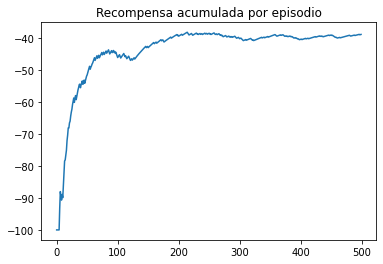

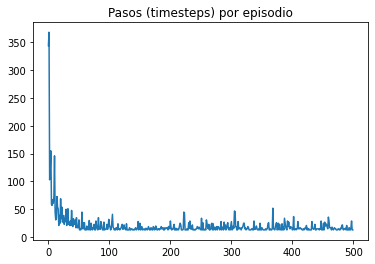

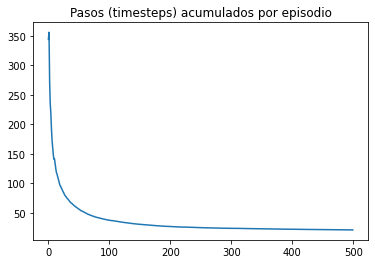

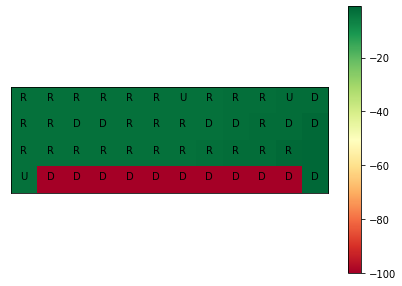


 Matriz de mejor acción-valor (en números): 

 [[  -3.29017489   -3.2785278    -3.2622017    -3.23942763   -3.20439072
    -3.15673431   -3.0908851    -3.01361215   -2.89123188   -2.73058195
    -2.50161682   -2.18675665]
 [  -3.29597648   -3.28461603   -3.26643549   -3.23885587   -3.19874837
    -3.14114188   -3.05880214   -2.94116516   -2.77309946   -2.53299986
    -2.18999999   -1.7       ]
 [  -3.28719571   -3.26742244   -3.23917492   -3.19882131   -3.1411733
    -3.058819     -2.94117      -2.7731       -2.533        -2.19
    -1.7          -1.        ]
 [  -3.301037   -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
maximum reward: 0   -13.0
dtype: float64


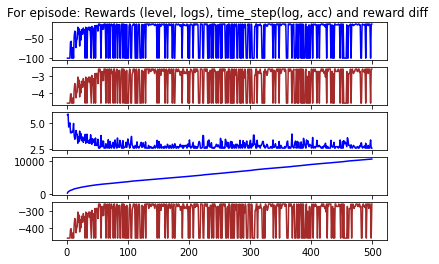

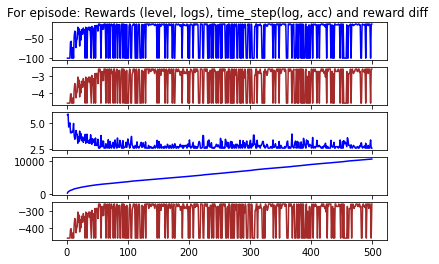

In [ ]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 0.7 # changing it (it was 1)
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

# Se ejecuta el proceso
avg_steps_per_episode, timesteps_ep, reward_ep = run()

# Important series
reward_ep_on_policy = pd.DataFrame(reward_ep)
timesteps_ep_on_policy = pd.DataFrame(timesteps_ep)
timesteps_ep_cum_on_policy =pd.DataFrame(np.cumsum(timesteps_ep))
q_on_policy = q

# Pre-set figures
plot_reward_per_episode(reward_ep) # Recompensa por episodio (accumulated)
plot_steps_per_episode(timesteps_ep) # Pasos por episodio
plot_steps_per_episode_smooth(timesteps_ep) # Smoothing
draw_value_matrix(q)


# Have some figures to compare
data=reward_ep_on_policy
def plot_something(data, ax=None, **kwargs):
    ax = ax or plt.gca()
    # Do some cool data transformations...
    
    return ax.plot(data, **kwargs,)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
plot_something(data, ax1, color='blue')
ax1.set_title('For episode: Rewards (level, logs), time_step(log, acc) and reward diff ')
plot_something(-np.log(-reward_ep_on_policy), ax2, color='brown')
#ax2.set_title('Rewards for episode, smoothed in logs')
plot_something(np.log(timesteps_ep_on_policy), ax3, color='blue')
plot_something(timesteps_ep_cum_on_policy, ax4, color='blue')
plot_something(-np.log(-reward_ep_on_policy).shift()*100, ax5, color='brown') # huge variations (convergence?)


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
plot_something(data, ax1, color='blue')
ax1.set_title('For episode: Rewards (level, logs), time_step(log, acc) and reward diff ')
plot_something(-np.log(-reward_ep_on_policy), ax2, color='brown')
plot_something(np.log(timesteps_ep_on_policy), ax3, color='blue')
plot_something(timesteps_ep_cum_on_policy, ax4, color='blue')
plot_something(-np.log(-reward_ep_on_policy).shift()*100, ax5, color='brown') # huge variations (convergence?)

print(f'maximum reward: {reward_ep_on_policy.max()}')

Convergence is not per-se assured because of the huge difference between the payment of an additional step and the fall reward. Adding more and more episodes does not reduce the maximum reward. The stochastic 

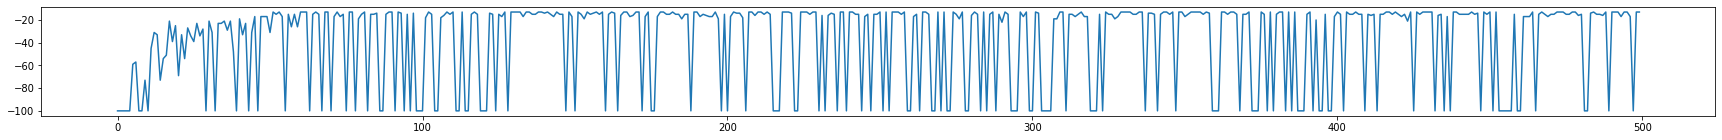

In [ ]:
fig = plt.figure(figsize=(30, 2))
ax = fig.add_subplot(111)
ax.plot(reward_ep_on_policy)

In [ ]:
env.close()

### Off Policy

In [ ]:
# Main functions

def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """    
    # off policy (?, impossing optimal selection)
    q[(state, action)] = q.get((state, action),0.0) + alpha*(reward+gamma*max([q.get((next_state, a), 0.0) for a in actions]) - q.get((state, action),0.0))

    pass

def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            

            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

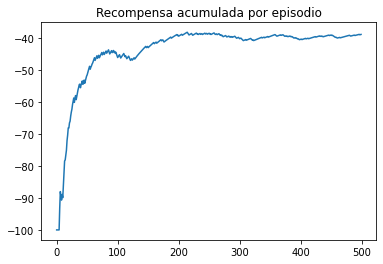

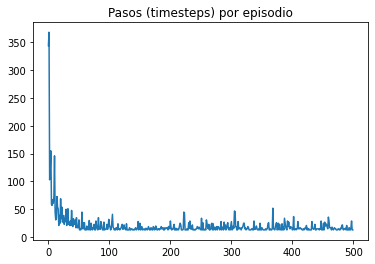

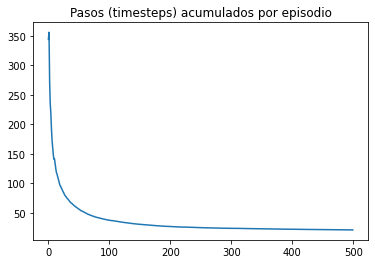

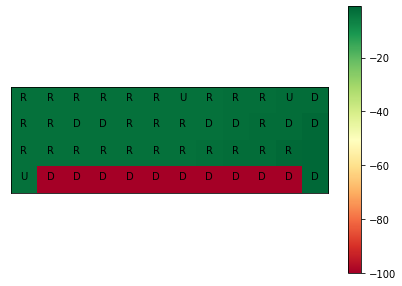


 Matriz de mejor acción-valor (en números): 

 [[  -3.29017489   -3.2785278    -3.2622017    -3.23942763   -3.20439072
    -3.15673431   -3.0908851    -3.01361215   -2.89123188   -2.73058195
    -2.50161682   -2.18675665]
 [  -3.29597648   -3.28461603   -3.26643549   -3.23885587   -3.19874837
    -3.14114188   -3.05880214   -2.94116516   -2.77309946   -2.53299986
    -2.18999999   -1.7       ]
 [  -3.28719571   -3.26742244   -3.23917492   -3.19882131   -3.1411733
    -3.058819     -2.94117      -2.7731       -2.533        -2.19
    -1.7          -1.        ]
 [  -3.301037   -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
maximum reward: 0   -13.0
dtype: float64


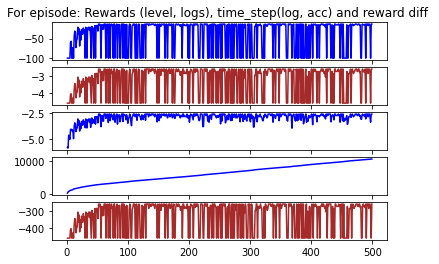

In [ ]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 0.7 # changing it (it was 1)
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

# Se ejecuta el proceso
avg_steps_per_episode, timesteps_ep, reward_ep = run()

# Important series
reward_ep_off_policy = pd.DataFrame(reward_ep)
timesteps_ep_off_policy = pd.DataFrame(timesteps_ep)
timesteps_ep_cum_off_policy =pd.DataFrame(np.cumsum(timesteps_ep))
q_off_policy = q

# Pre-set figures
plot_reward_per_episode(reward_ep) # Recompensa por episodio (accumulated)
plot_steps_per_episode(timesteps_ep) # Pasos por episodio
plot_steps_per_episode_smooth(timesteps_ep) # Smoothing
draw_value_matrix(q)


# Have some figures to compare
data=reward_ep_on_policy
def plot_something(data, ax=None, **kwargs):
    ax = ax or plt.gca()
    # Do some cool data transformations...
    
    return ax.plot(data, **kwargs,)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
plot_something(data, ax1, color='blue')
ax1.set_title('For episode: Rewards (level, logs), time_step(log, acc) and reward diff ')
plot_something(-np.log(-reward_ep_on_policy), ax2, color='brown')
plot_something(-np.log(timesteps_ep_on_policy), ax3, color='blue')
plot_something(timesteps_ep_cum_on_policy, ax4, color='blue')
plot_something(-np.log(-reward_ep_on_policy).shift()*100, ax5, color='brown') # huge variations (convergence?)


print(f'maximum reward: {reward_ep_on_policy.max()}')

### Benchmark

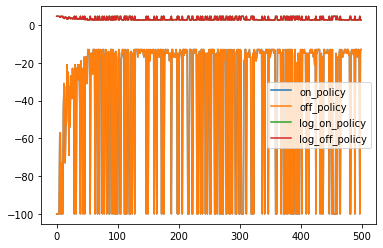

In [ ]:
# Have some figures to compare
rewards = {}
rewards['on_policy']=reward_ep_on_policy[0]
rewards['off_policy']=reward_ep_off_policy[0]
rewards['log_on_policy']=np.log(-reward_ep_on_policy[0])
rewards['log_off_policy']=np.log(-reward_ep_off_policy[0])
rewards=pd.DataFrame.from_dict(rewards)
rewards.plot()

' The off policy exhibits more variability also (which reflects the more\n risky attitude) '

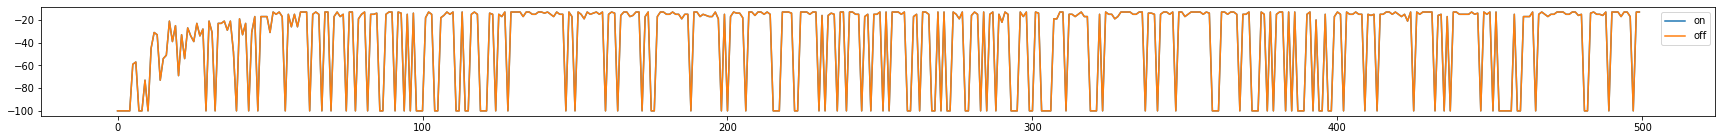

In [ ]:
# Comparing rewards
data=pd.concat([rewards['on_policy'], rewards['off_policy']], axis=1, keys=['on', 'off'])
fig =data.plot(figsize=(30, 2))
''' The off policy exhibits more variability also (which reflects the more
 risky attitude) '''

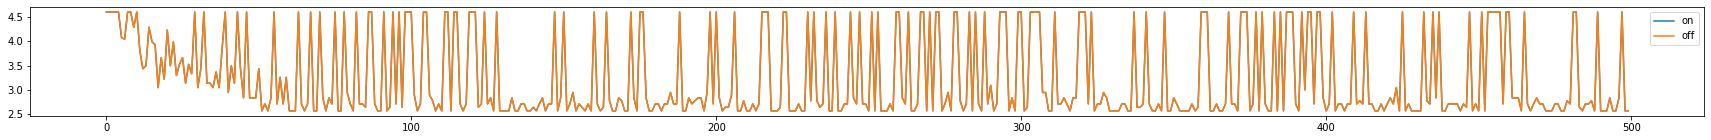

In [ ]:
# Comparing rewards in logs
data=pd.concat([rewards['log_on_policy'], rewards['log_off_policy']], axis=1, keys=['on', 'off'])
fig =data.plot(figsize=(30, 2))
# In few steps episodes off policy reaches objective with no many costs,
# But the stochastic nature shows that it gets more falls and losses, see graph in logs

In [ ]:
# Have some figures to compare
def plot_something_benchmark(data, ax=None, **kwargs):
    ax = ax or plt.gca()
    # Do some cool data transformations...
    
    return ax.plot(data, **kwargs,)

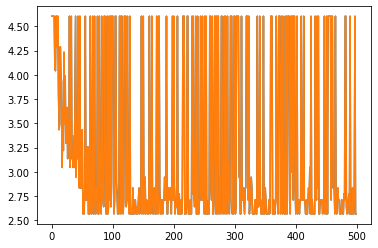

In [ ]:
plot_something_benchmark(data)

### Fastest learning process

#### On policy

In [ ]:
# Main functions
  # Learning method
def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """    
    # on policy 
    q[(state, action)] = q.get((state, action),0.0) + alpha*(reward+gamma*q.get((next_state, next_action),0.0) - q.get((state, action),0.0))
    # off policy (?, impossing optimal selection)
    ##q[(state, action)] = q.get((state, action),0.0) + alpha*(reward+gamma*max([q.get((next_state, a), 0.0) for a in actions]) - q.get((state, action),0.0))
    
    pass

def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

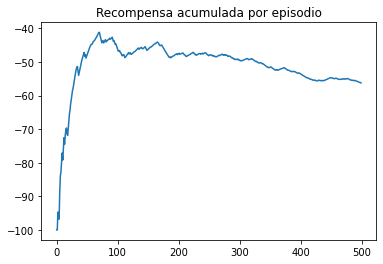

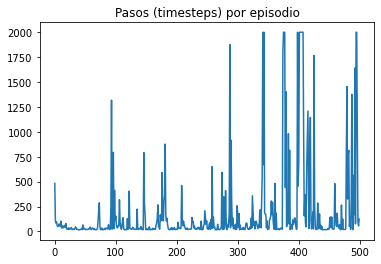

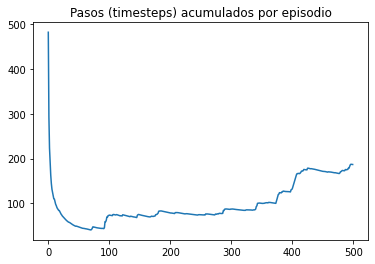

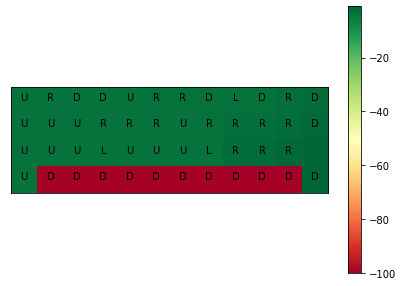


 Matriz de mejor acción-valor (en números): 

 [[  -3.48572001   -3.36069433   -3.35577746   -3.35094764   -3.35899183
    -3.27347336   -3.23225723   -3.11697965   -3.5256129    -2.99869469
    -2.58419064   -2.1907402 ]
 [  -3.34025483   -3.34406731   -3.34787294   -3.33718274   -3.35329187
    -3.36307126   -3.40962328   -2.95876777   -2.88612093   -2.58572675
    -2.27820137   -1.700441  ]
 [  -3.34642581   -3.35068468   -3.34094896   -3.39063788   -3.38493514
    -3.33570199   -3.34966472   -3.3792199    -2.53300066   -2.19
    -1.7          -1.        ]
 [  -3.37180132 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
maximum reward: 0   -15.0
dtype: float64


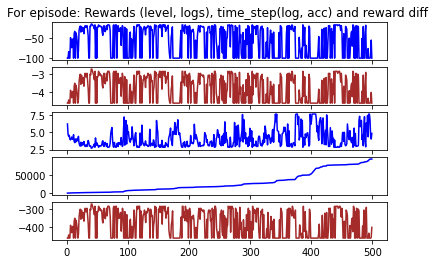

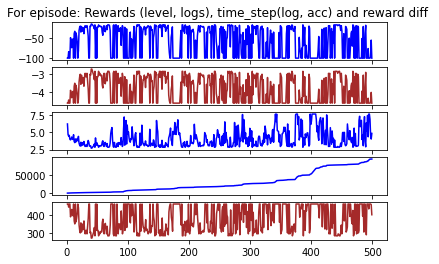

In [ ]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.9
gamma = 0.7 # changing it (it was 1)
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

# Se ejecuta el proceso
avg_steps_per_episode, timesteps_ep, reward_ep = run()

# Important series
reward_ep_on_policy = pd.DataFrame(reward_ep)
timesteps_ep_on_policy = pd.DataFrame(timesteps_ep)
timesteps_ep_cum_on_policy =pd.DataFrame(np.cumsum(timesteps_ep))
q_on_policy = q

# Pre-set figures
plot_reward_per_episode(reward_ep) # Recompensa por episodio (accumulated)
plot_steps_per_episode(timesteps_ep) # Pasos por episodio
plot_steps_per_episode_smooth(timesteps_ep) # Smoothing
draw_value_matrix(q)


# Have some figures to compare
data=reward_ep_on_policy
def plot_something(data, ax=None, **kwargs):
    ax = ax or plt.gca()
    # Do some cool data transformations...
    
    return ax.plot(data, **kwargs,)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
plot_something(data, ax1, color='blue')
ax1.set_title('For episode: Rewards (level, logs), time_step(log, acc) and reward diff ')
plot_something(-np.log(-reward_ep_on_policy), ax2, color='brown')
plot_something(np.log(timesteps_ep_on_policy), ax3, color='blue')
plot_something(timesteps_ep_cum_on_policy, ax4, color='blue')
plot_something(-np.log(-reward_ep_on_policy).shift()*100, ax5, color='brown') # huge variations (convergence?)


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
plot_something(data, ax1, color='blue')
ax1.set_title('For episode: Rewards (level, logs), time_step(log, acc) and reward diff ')
plot_something(-np.log(-reward_ep_on_policy), ax2, color='brown')
plot_something(np.log(timesteps_ep_on_policy), ax3, color='blue')
plot_something(timesteps_ep_cum_on_policy, ax4, color='blue')
plot_something(np.log(-reward_ep_on_policy).shift()*100, ax5, color='brown') # huge variations (convergence?)

print(f'maximum reward: {reward_ep_on_policy.max()}')

#### Off Policy

In [ ]:
# Main functions

def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """    
    # off policy (?, impossing optimal selection)
    q[(state, action)] = q.get((state, action),0.0) + alpha*(reward+gamma*max([q.get((next_state, a), 0.0) for a in actions]) - q.get((state, action),0.0))


    pass

def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            

            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

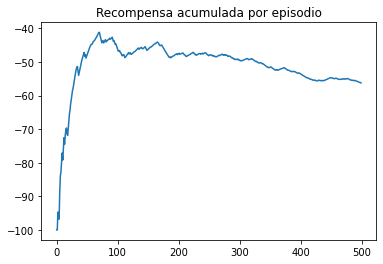

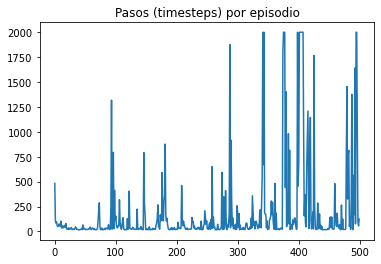

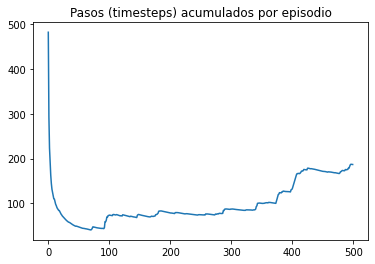

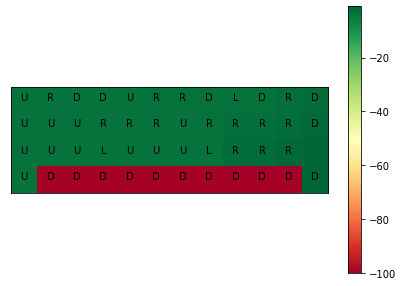


 Matriz de mejor acción-valor (en números): 

 [[  -3.48572001   -3.36069433   -3.35577746   -3.35094764   -3.35899183
    -3.27347336   -3.23225723   -3.11697965   -3.5256129    -2.99869469
    -2.58419064   -2.1907402 ]
 [  -3.34025483   -3.34406731   -3.34787294   -3.33718274   -3.35329187
    -3.36307126   -3.40962328   -2.95876777   -2.88612093   -2.58572675
    -2.27820137   -1.700441  ]
 [  -3.34642581   -3.35068468   -3.34094896   -3.39063788   -3.38493514
    -3.33570199   -3.34966472   -3.3792199    -2.53300066   -2.19
    -1.7          -1.        ]
 [  -3.37180132 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
maximum reward: 0   -15.0
dtype: float64


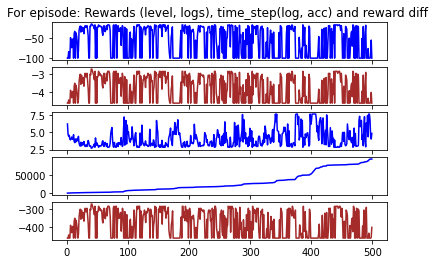

In [ ]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.9
gamma = 0.7 # changing it (it was 1)
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

# Se ejecuta el proceso
avg_steps_per_episode, timesteps_ep, reward_ep = run()

# Important series
reward_ep_off_policy = pd.DataFrame(reward_ep)
timesteps_ep_off_policy = pd.DataFrame(timesteps_ep)
timesteps_ep_cum_off_policy =pd.DataFrame(np.cumsum(timesteps_ep))
q_off_policy = q

# Pre-set figures
plot_reward_per_episode(reward_ep) # Recompensa por episodio (accumulated)
plot_steps_per_episode(timesteps_ep) # Pasos por episodio
plot_steps_per_episode_smooth(timesteps_ep) # Smoothing
draw_value_matrix(q)


# Have some figures to compare
data=reward_ep_on_policy
def plot_something(data, ax=None, **kwargs):
    ax = ax or plt.gca()
    # Do some cool data transformations...
    
    return ax.plot(data, **kwargs,)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
plot_something(data, ax1, color='blue')
ax1.set_title('For episode: Rewards (level, logs), time_step(log, acc) and reward diff ')
plot_something(-np.log(-reward_ep_on_policy), ax2, color='brown')
plot_something(np.log(timesteps_ep_on_policy), ax3, color='blue')
plot_something(timesteps_ep_cum_on_policy, ax4, color='blue')
plot_something(-np.log(-reward_ep_on_policy).shift()*100, ax5, color='brown') # huge variations (convergence?)

print(f'maximum reward: {reward_ep_on_policy.max()}')

#### Benchmarking

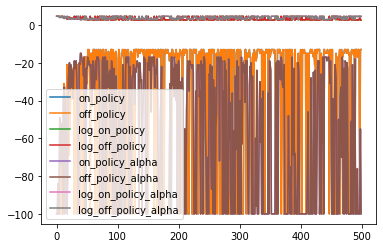

In [ ]:
# Have some figures to compare
#rewards = {}
rewards['on_policy_alpha']=reward_ep_on_policy[0]
rewards['off_policy_alpha']=reward_ep_off_policy[0]
rewards['log_on_policy_alpha']=np.log(-reward_ep_on_policy[0])
rewards['log_off_policy_alpha']=np.log(-reward_ep_off_policy[0])
rewards=pd.DataFrame.from_dict(rewards)
rewards.plot()

,on,on_alpha
count,500.000000,500.000000
mean,3.242390,3.793565
std,0.860307,0.709352
min,2.564949,2.708050
25%,2.564949,3.079412
50%,2.708050,3.663562
75%,4.605170,4.605170
max,4.605170,4.605170


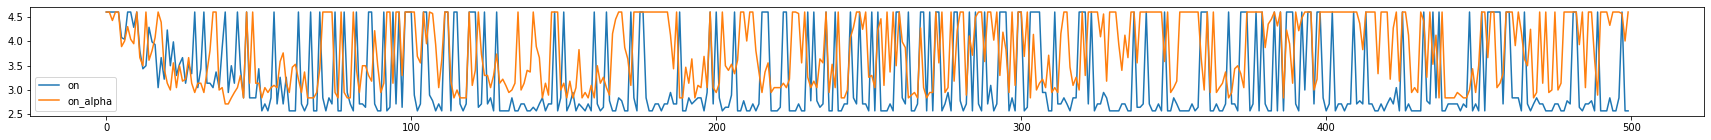

In [ ]:
# Comparing rewards in logs
data=pd.concat([rewards['log_on_policy'], rewards['log_on_policy_alpha']], axis=1, keys=['on', 'on_alpha'])
fig =data.plot(figsize=(30, 2))
# The faster the learning process the close that on and off policy are,
# That is why the learning process with higher alpha is more variable,
# although it is expected to be less volatil (it gets to their objective quicker)
# The range of the rewards has increased, although the volatility is lower
# The mean reward thus is larger
data.describe()

,off,off_alpha
count,500.000000,500.000000
mean,3.242390,3.793565
std,0.860307,0.709352
min,2.564949,2.708050
25%,2.564949,3.079412
50%,2.708050,3.663562
75%,4.605170,4.605170
max,4.605170,4.605170


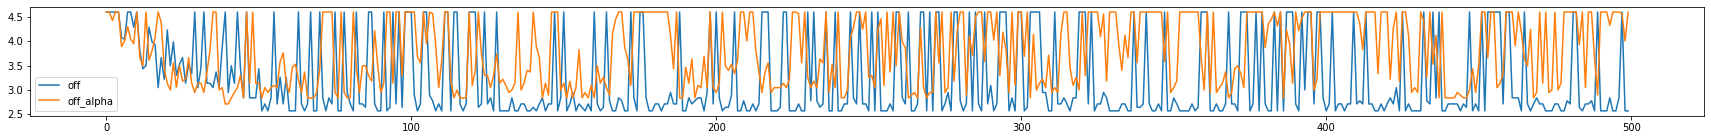

In [ ]:
# Comparing rewards in logs
data=pd.concat([rewards['log_off_policy'], rewards['log_off_policy_alpha']], axis=1, keys=['off', 'off_alpha'])
fig =data.plot(figsize=(30, 2))
data.describe()
# Two quick paths to objective with less losses for the quick learning
# Note that the mean reward of the off_learning is lower (less losses)

### Larger epsilon

#### On policy

In [ ]:
# Main functions
  # Learning method
def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """    
    # on policy 
    q[(state, action)] = q.get((state, action),0.0) + alpha*(reward+gamma*q.get((next_state, next_action),0.0) - q.get((state, action),0.0))
   
    pass

def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

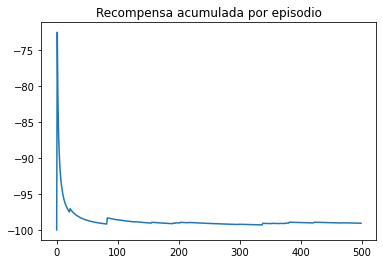

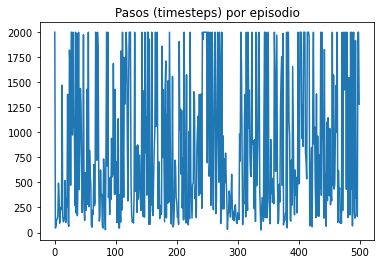

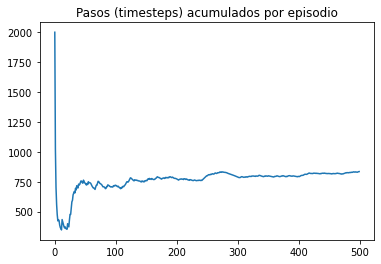

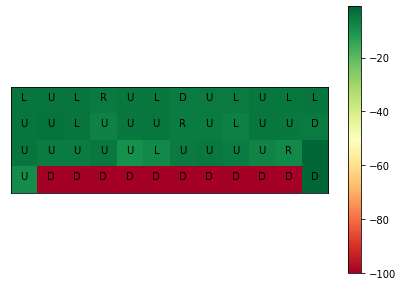


 Matriz de mejor acción-valor (en números): 

 [[  -3.77145694   -3.71186195   -4.01696155   -5.03102032   -4.53183153
    -4.74322315   -5.30181049   -5.00309252   -5.23185958   -4.19239981
    -4.23038625   -3.98134787]
 [  -3.82928465   -3.69550085   -4.05280625   -6.5003344    -4.69015689
    -4.35195482   -5.31483736   -5.33368344   -6.22506682   -4.26012741
    -4.54912866   -5.1990599 ]
 [  -3.8212326    -5.38868505   -5.306481     -4.51518487   -9.67055024
    -7.97307863   -5.23711108   -4.60717772   -5.56439061   -6.93048457
    -8.21797162   -1.        ]
 [  -8.392371   -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
maximum reward: 0   -26.0
dtype: float64


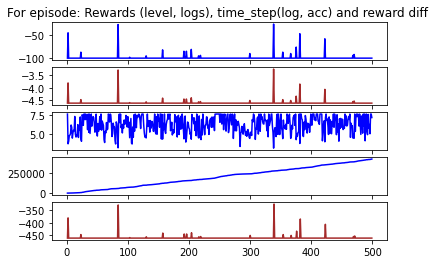

In [ ]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 0.7 # changing it (it was 1)
epsilon = 0.7
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

# Se ejecuta el proceso
avg_steps_per_episode, timesteps_ep, reward_ep = run()

# Important series
reward_ep_on_policy = pd.DataFrame(reward_ep)
timesteps_ep_on_policy = pd.DataFrame(timesteps_ep)
timesteps_ep_cum_on_policy =pd.DataFrame(np.cumsum(timesteps_ep))
q_on_policy = q

# Pre-set figures
plot_reward_per_episode(reward_ep) # Recompensa por episodio (accumulated)
plot_steps_per_episode(timesteps_ep) # Pasos por episodio
plot_steps_per_episode_smooth(timesteps_ep) # Smoothing
draw_value_matrix(q)


# Have some figures to compare
data=reward_ep_on_policy
def plot_something(data, ax=None, **kwargs):
    ax = ax or plt.gca()
    # Do some cool data transformations...
    
    return ax.plot(data, **kwargs,)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
plot_something(data, ax1, color='blue')
ax1.set_title('For episode: Rewards (level, logs), time_step(log, acc) and reward diff ')
plot_something(-np.log(-reward_ep_on_policy), ax2, color='brown')
#ax2.set_title('Rewards for episode, smoothed in logs')
plot_something(np.log(timesteps_ep_on_policy), ax3, color='blue')
plot_something(timesteps_ep_cum_on_policy, ax4, color='blue')
plot_something(-np.log(-reward_ep_on_policy).shift()*100, ax5, color='brown') # huge variations (convergence?)

print(f'maximum reward: {reward_ep_on_policy.max()}')

#### Off policy

In [ ]:
# Main functions

def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """    
    # off policy (?, impossing optimal selection)
    q[(state, action)] = q.get((state, action),0.0) + alpha*(reward+gamma*max([q.get((next_state, a), 0.0) for a in actions]) - q.get((state, action),0.0))

    pass

def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            

            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

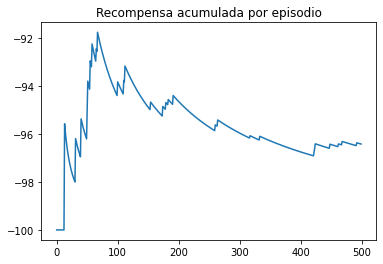

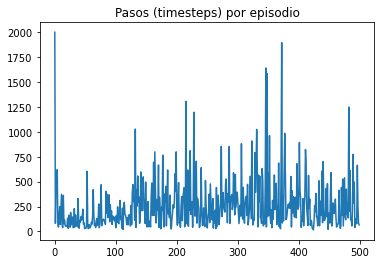

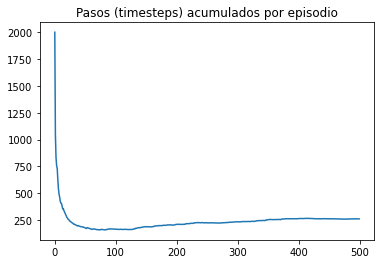

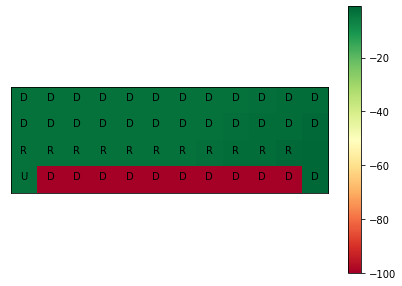


 Matriz de mejor acción-valor (en números): 

 [[  -3.3107259    -3.301037     -3.28719571   -3.26742244   -3.23917492
    -3.19882131   -3.1411733    -3.058819     -2.94117      -2.7731
    -2.533        -2.19      ]
 [  -3.301037     -3.28719571   -3.26742244   -3.23917492   -3.19882131
    -3.1411733    -3.058819     -2.94117      -2.7731       -2.533
    -2.19         -1.7       ]
 [  -3.28719571   -3.26742244   -3.23917492   -3.19882131   -3.1411733
    -3.058819     -2.94117      -2.7731       -2.533        -2.19
    -1.7          -1.        ]
 [  -3.301037   -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
maximum reward: 0   -26.0
dtype: float64


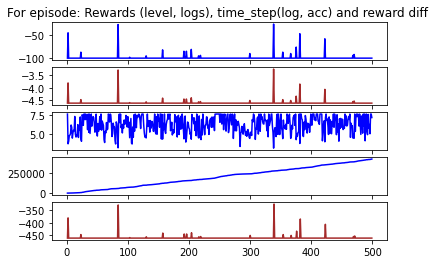

In [ ]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 0.7 # changing it (it was 1)
epsilon = 0.7
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

# Se ejecuta el proceso
avg_steps_per_episode, timesteps_ep, reward_ep = run()

# Important series
reward_ep_off_policy = pd.DataFrame(reward_ep)
timesteps_ep_off_policy = pd.DataFrame(timesteps_ep)
timesteps_ep_cum_off_policy =pd.DataFrame(np.cumsum(timesteps_ep))
q_off_policy = q

# Pre-set figures
plot_reward_per_episode(reward_ep) # Recompensa por episodio (accumulated)
plot_steps_per_episode(timesteps_ep) # Pasos por episodio
plot_steps_per_episode_smooth(timesteps_ep) # Smoothing
draw_value_matrix(q)


# Have some figures to compare
data=reward_ep_on_policy
def plot_something(data, ax=None, **kwargs):
    ax = ax or plt.gca()
    # Do some cool data transformations...
    
    return ax.plot(data, **kwargs,)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
plot_something(data, ax1, color='blue')
ax1.set_title('For episode: Rewards (level, logs), time_step(log, acc) and reward diff ')
plot_something(-np.log(-reward_ep_on_policy), ax2, color='brown')
plot_something(np.log(timesteps_ep_on_policy), ax3, color='blue')
plot_something(timesteps_ep_cum_on_policy, ax4, color='blue')
plot_something(-np.log(-reward_ep_on_policy).shift()*100, ax5, color='brown') # huge variations (convergence?)


print(f'maximum reward: {reward_ep_on_policy.max()}')

#### Benchmarking

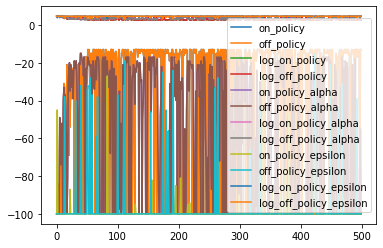

In [ ]:
# Have some figures to compare

rewards['on_policy_epsilon']=reward_ep_on_policy[0]
rewards['off_policy_epsilon']=reward_ep_off_policy[0]
rewards['log_on_policy_epsilon']=np.log(-reward_ep_on_policy[0])
rewards['log_off_policy_epsilon']=np.log(-reward_ep_off_policy[0])
rewards=pd.DataFrame.from_dict(rewards)
rewards.plot()

" A higher epsilon reduces the stochastic nature of the learning process so it is 'easy' to get to the optimum, but the falls are constant. That is why the variability is less ('more certain')\nand standard deviation (of the on and off policy) is lower."

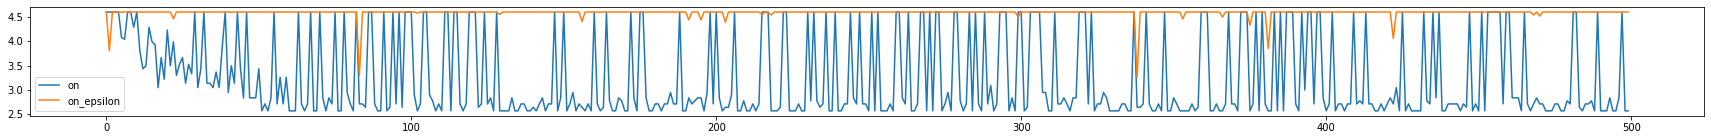

In [ ]:
# Comparing rewards in logs
data=pd.concat([rewards['log_on_policy'], rewards['log_on_policy_epsilon']], axis=1, keys=['on', 'on_epsilon'])
fig =data.plot(figsize=(30, 2))
data.describe()
''' A higher epsilon reduces the stochastic nature of the learning process so it is 'easy' to get to the optimum, but the falls are constant. That is why the variability is less ('more certain')
and standard deviation (of the on and off policy) is lower.'''

' The range in the off policy is however shorter in the off policy\n(we know better the outcome with higher epsilon)'

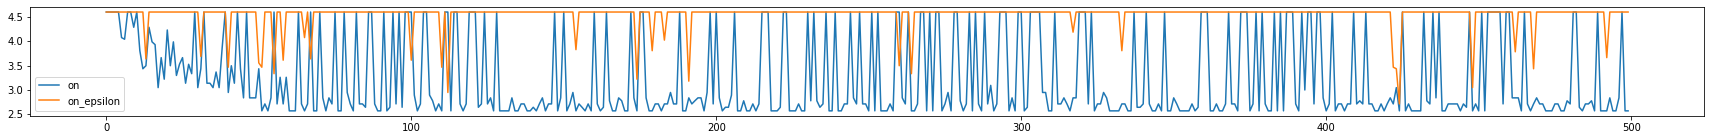

In [ ]:
data=pd.concat([rewards['log_off_policy'], rewards['log_off_policy_epsilon']], axis=1, keys=['on', 'on_epsilon'])
fig =data.plot(figsize=(30, 2))
data.describe()
''' The range in the off policy is however shorter in the off policy
(we know better the outcome with higher epsilon)'''

### Low discount rate

#### On policy

In [ ]:
# Main functions
  # Learning method
def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """    
    # on policy 
    q[(state, action)] = q.get((state, action),0.0) + alpha*(reward+gamma*q.get((next_state, next_action),0.0) - q.get((state, action),0.0))
    
    pass

def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

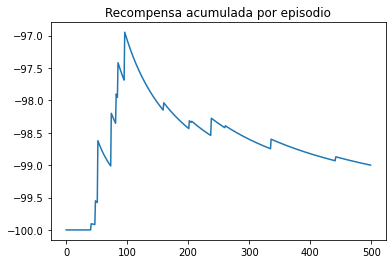

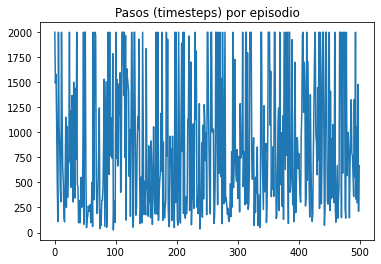

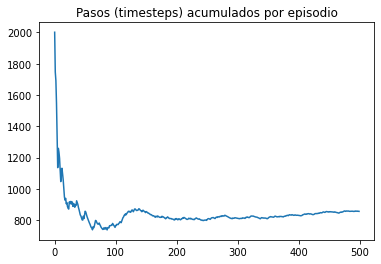

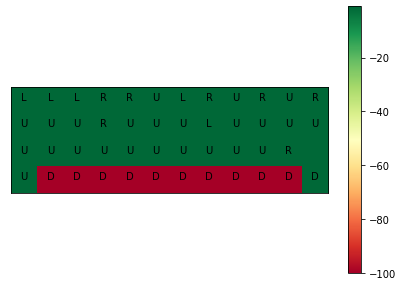


 Matriz de mejor acción-valor (en números): 

 [[  -1.01010101   -1.01010101   -1.01010101   -1.01010101   -1.01010101
    -1.01010101   -1.01010101   -1.01010101   -1.01010103   -1.01010101
    -1.01010104   -1.01010101]
 [  -1.01010101   -1.01010102   -1.01010101   -1.01010127   -1.01010101
    -1.01010101   -1.01010103   -1.01010132   -1.01010101   -1.01010312
    -1.01010103   -1.01010101]
 [  -1.0101049    -1.01010108   -1.01010134   -1.01010107   -1.01010314
    -1.01010292   -1.0104415    -1.01038137   -1.01018615   -1.01089792
    -1.01005759   -1.        ]
 [  -1.01013042 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
maximum reward: 0   -26.0
dtype: float64


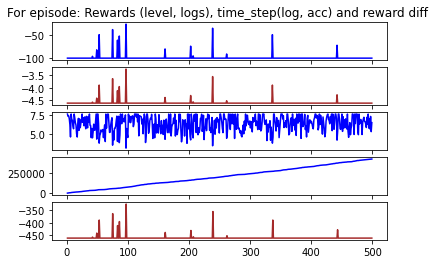

In [ ]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 0.01 # changing it (it was 1)
epsilon = 0.7
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

# Se ejecuta el proceso
avg_steps_per_episode, timesteps_ep, reward_ep = run()

# Important series
reward_ep_on_policy = pd.DataFrame(reward_ep)
timesteps_ep_on_policy = pd.DataFrame(timesteps_ep)
timesteps_ep_cum_on_policy =pd.DataFrame(np.cumsum(timesteps_ep))
q_on_policy = q

# Pre-set figures
plot_reward_per_episode(reward_ep) # Recompensa por episodio (accumulated)
plot_steps_per_episode(timesteps_ep) # Pasos por episodio
plot_steps_per_episode_smooth(timesteps_ep) # Smoothing
draw_value_matrix(q)


# Have some figures to compare
data=reward_ep_on_policy
def plot_something(data, ax=None, **kwargs):
    ax = ax or plt.gca()
    # Do some cool data transformations...
    
    return ax.plot(data, **kwargs,)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
plot_something(data, ax1, color='blue')
ax1.set_title('For episode: Rewards (level, logs), time_step(log, acc) and reward diff ')
plot_something(-np.log(-reward_ep_on_policy), ax2, color='brown')
plot_something(np.log(timesteps_ep_on_policy), ax3, color='blue')
plot_something(timesteps_ep_cum_on_policy, ax4, color='blue')
plot_something(-np.log(-reward_ep_on_policy).shift()*100, ax5, color='brown') # huge variations (convergence?)

print(f'maximum reward: {reward_ep_on_policy.max()}')

#### Off Policy

In [ ]:
# Main functions

def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """    
    # off policy (?, impossing optimal selection)
    q[(state, action)] = q.get((state, action),0.0) + alpha*(reward+gamma*max([q.get((next_state, a), 0.0) for a in actions]) - q.get((state, action),0.0))

    pass

def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            

            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

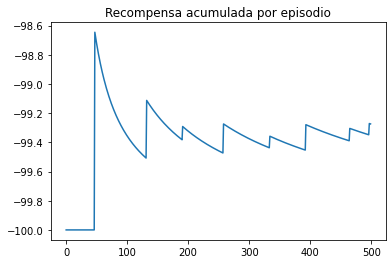

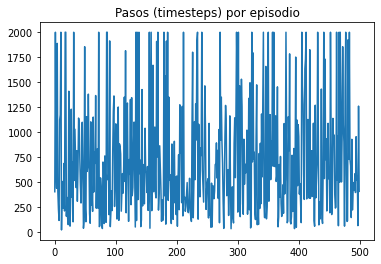

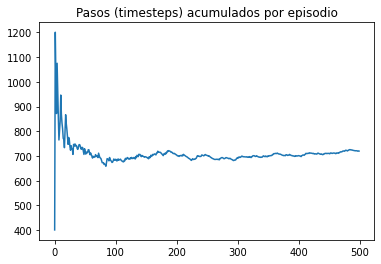

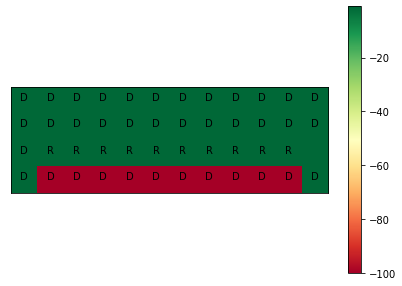


 Matriz de mejor acción-valor (en números): 

 [[  -1.01010101   -1.01010101   -1.01010101   -1.01010101   -1.01010101
    -1.01010101   -1.01010101   -1.01010101   -1.01010101   -1.01010101
    -1.010101     -1.0101    ]
 [  -1.01010101   -1.01010101   -1.01010101   -1.01010101   -1.01010101
    -1.01010101   -1.01010101   -1.01010101   -1.01010101   -1.010101
    -1.0101       -1.01      ]
 [  -1.01010101   -1.01010101   -1.01010101   -1.01010101   -1.01010101
    -1.01010101   -1.01010101   -1.01010101   -1.010101     -1.0101
    -1.01         -1.        ]
 [  -1.01010101 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
maximum reward: 0   -26.0
dtype: float64


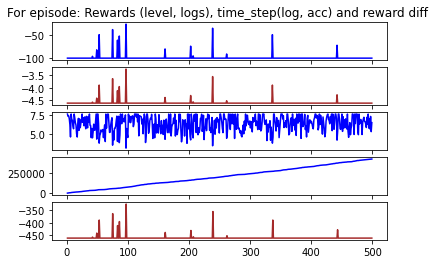

In [ ]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 0.01
epsilon = 0.7
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

# Se ejecuta el proceso
avg_steps_per_episode, timesteps_ep, reward_ep = run()

# Important series
reward_ep_off_policy = pd.DataFrame(reward_ep)
timesteps_ep_off_policy = pd.DataFrame(timesteps_ep)
timesteps_ep_cum_off_policy =pd.DataFrame(np.cumsum(timesteps_ep))
q_off_policy = q

# Pre-set figures
plot_reward_per_episode(reward_ep) # Recompensa por episodio (accumulated)
plot_steps_per_episode(timesteps_ep) # Pasos por episodio
plot_steps_per_episode_smooth(timesteps_ep) # Smoothing
draw_value_matrix(q)


# Have some figures to compare
data=reward_ep_on_policy
def plot_something(data, ax=None, **kwargs):
    ax = ax or plt.gca()
    # Do some cool data transformations...
    
    return ax.plot(data, **kwargs,)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
plot_something(data, ax1, color='blue')
ax1.set_title('For episode: Rewards (level, logs), time_step(log, acc) and reward diff ')
plot_something(-np.log(-reward_ep_on_policy), ax2, color='brown')
plot_something(np.log(timesteps_ep_on_policy), ax3, color='blue')
plot_something(timesteps_ep_cum_on_policy, ax4, color='blue')
plot_something(-np.log(-reward_ep_on_policy).shift()*100, ax5, color='brown') # huge variations (convergence?)


print(f'maximum reward: {reward_ep_on_policy.max()}')

In [ ]:
''' When \u03B3 is zero, the future does not matter. 
So, when it is close to zero the agent will take more risk to get to
the final point and we will observe the lowest reward prevailing in
 most of the cases. That is why the on and off policies do look alike'''

' When γ is zero, the future does not matter. \nSo, when it is close to zero the agent will take more risk to get to\nthe final point and we will observe the lowest reward prevailing in\n most of the cases'

#### Benchmarking

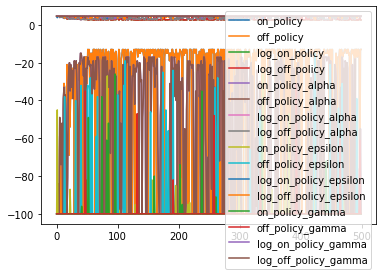

In [ ]:
# Have some figures to compare

rewards['on_policy_gamma']=reward_ep_on_policy[0]
rewards['off_policy_gamma']=reward_ep_off_policy[0]
rewards['log_on_policy_gamma']=np.log(-reward_ep_on_policy[0])
rewards['log_off_policy_gamma']=np.log(-reward_ep_off_policy[0])
rewards=pd.DataFrame.from_dict(rewards)
rewards.plot()

' This figure confirms the previous conclusion. Risk taking behaviour for less\ncare about the future implies more fallouts.'

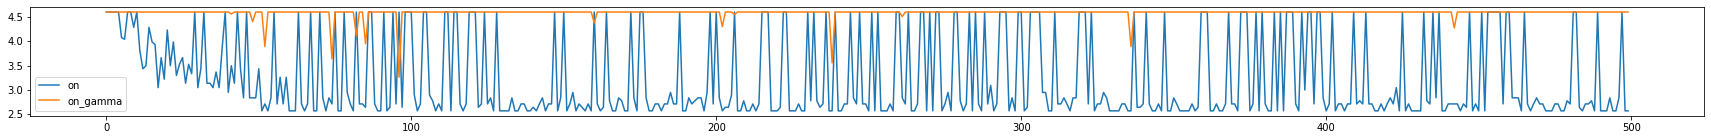

In [ ]:
# Comparing rewards in logs
data=pd.concat([rewards['log_on_policy'], rewards['log_on_policy_gamma']], axis=1, keys=['on', 'on_gamma'])
fig =data.plot(figsize=(30, 2))
data.describe()
''' This figure confirms the previous conclusion. Risk taking behaviour for less
care about the future implies more fallouts.'''

' Again, the off policy behaviour confirms previous conclusions'

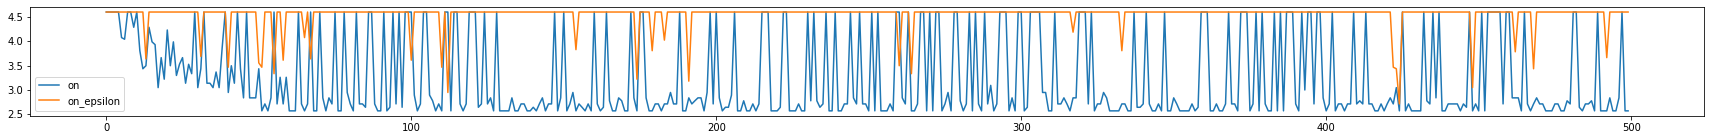

In [ ]:
data=pd.concat([rewards['log_off_policy'], rewards['log_off_policy_epsilon']], axis=1, keys=['on', 'on_epsilon'])
fig =data.plot(figsize=(30, 2))
data.describe()
''' Again, the off policy behaviour confirms previous conclusions'''

#### Soft-Max (this is optional!!)

In [ ]:
from numpy import exp
 
# calculate the softmax of a vector
def softmax(vector):
	e = exp(vector)
	return e / e.sum()

In [ ]:
# Grl action procedure (should soft-max here be added?)
# Basic moves

def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = softmax([q.get((state, a), 0.0) for a in actions])
    max_q = max(q_values)

#
    if random_state.uniform() < epsilon:
        return random_state.choice(actions)  # a random action is selected

    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        i = q_values.index(max_q)

    return actions[i]

In [ ]:
# example of a function for calculating softmax for a list of numbers
from numpy import exp
 
# calculate the softmax of a vector
def softmax(vector):
	e = exp(vector)
	return e / e.sum()

In [ ]:
# used to select action to take
def policy(state, t):
    p = np.array([q[(state,x)]/t for x in range(env.action_space.n)])
    prob_actions = np.exp(p) / np.sum(np.exp(p))
    cumulative_probability = 0.0
    choice = random.uniform(0,1)
    for a,pr in enumerate(prob_actions):
        cumulative_probability += pr
        if cumulative_probability > choice:
            return a